In [1]:
# Imports
import sys
sys.path.append('../Classes')
from flight_physics import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from mpl_toolkits import mplot3d
import numpy as np
import math

### Hamilton-Jacobi PDE Residual
$ G(x,t,p) = \frac {\partial \hat{V}_p (x,t)} {\partial t} + \min \{ 0, \sup_{u \in U} \frac {\partial \hat{V}_p (x,t)} {\partial x} f(x, u) \} $ \
$ \hat{V}_p (x, T) = l(x) $

In [135]:
# Network residuals
def G(x, t, Vp):
    x.requires_grad = True
    t.requires_grad = True

    y = Vp(x, t)

    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    # correct controls?
    
    dot = torch.sum(y_x * f(x, u(x)), -1) # better function to use for dot product?
    out = y_t - torch.relu( - dot )

    return out

# Cost criterion
def H(x, t, Vp):
    return torch.sum(G(x, t, Vp) ** 2)

def loss(x, t, Vp):
    df_loss = H(x, t, Vp)
    tz = T * torch.ones(t.size())
    dg_loss = torch.sum((Vp(x,tz) - l(x)) ** 2)
    loss_ = df_loss + dg_loss
    return loss_, df_loss, dg_loss

### Approximation Function

In [138]:
class ValueFunction(nn.Module):
    def __init__(self,input_size=3,output_size=1):
        super(ValueFunction, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    # Normalize to [0,1] x [0,1] x [0,1]
    def norm(self,x,t):
        xout = torch.zeros(x.size())
        tout = torch.zeros(t.size())
        xout[:,0] = x[:,0] - Vmin; xout[:,0] = x[:,0] / (Vmax - Vmin)
        xout[:,1] = x[:,1] - ymin; xout[:,1] = x[:,1] / (ymax - ymin)
        tout = t / T
        return xout, tout

    def forward(self,x,t):
        x_, t_ = self.norm(x, t)
        # Forward propagation
        inp = torch.cat((x_, t_.unsqueeze(-1)), -1)
        z = torch.sin(self.linear1(inp))
        z = torch.sin(self.linear2(z))
        z = torch.sin(self.linear3(z))
        return z.squeeze()

valueApprox = ValueFunction()

In [24]:
# Loading data

xi = torch.load("../Data/xi_roi.pt")
ti = torch.load("../Data/ti_roi.pt")

In [139]:
optimizer = torch.optim.Adam(valueApprox.parameters(), lr=0.001)
losses = []
#train the neural network for 5 epochs
for epoch in range(20000):      
    #reset gradients
    optimizer.zero_grad()
        
    #calculate the loss
    loss_ = loss(xi, ti, valueApprox)
    losses.append(np.array(torch.tensor(loss_, requires_grad=False)))
    if epoch % 1000 == 0:
        print("Epoch: {e} - Loss: {l:.6f} - Loss (df): {dfl:.6f} - Loss (dg): {dgl:.6f}".format(e=epoch, l=loss_[0].item(), dfl=loss_[1].item(), dgl=loss_[2].item()))
        
    #backpropagation
    loss_[0].backward(retain_graph=True)
    
    #update the parameters
    optimizer.step()

Epoch: 0 - Loss: 52.906082 - Loss (df): 2.646304 - Loss (dg): 50.259777
Epoch: 1000 - Loss: 11.863374 - Loss (df): 0.018579 - Loss (dg): 11.844794
Epoch: 2000 - Loss: 5.839500 - Loss (df): 0.166430 - Loss (dg): 5.673070
Epoch: 3000 - Loss: 1.250561 - Loss (df): 0.016951 - Loss (dg): 1.233610
Epoch: 4000 - Loss: 0.576588 - Loss (df): 0.035467 - Loss (dg): 0.541121
Epoch: 5000 - Loss: 0.557088 - Loss (df): 0.030370 - Loss (dg): 0.526718
Epoch: 6000 - Loss: 0.548411 - Loss (df): 0.027025 - Loss (dg): 0.521385
Epoch: 7000 - Loss: 0.538893 - Loss (df): 0.021890 - Loss (dg): 0.517003
Epoch: 8000 - Loss: 0.531874 - Loss (df): 0.017696 - Loss (dg): 0.514178
Epoch: 9000 - Loss: 0.525193 - Loss (df): 0.016123 - Loss (dg): 0.509070
Epoch: 10000 - Loss: 0.520504 - Loss (df): 0.015535 - Loss (dg): 0.504969
Epoch: 11000 - Loss: 0.516567 - Loss (df): 0.015095 - Loss (dg): 0.501472
Epoch: 12000 - Loss: 0.513125 - Loss (df): 0.014822 - Loss (dg): 0.498303
Epoch: 13000 - Loss: 0.509370 - Loss (df): 0.01

### Value Function Visualization

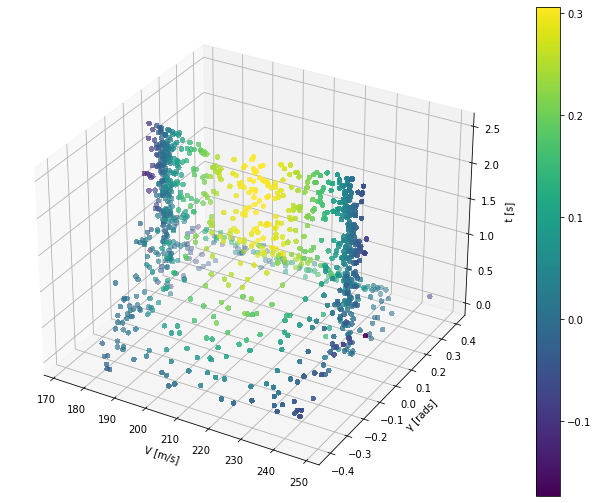

In [199]:
# Creating figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot

cc = valueApprox(xi, ti).detach().numpy()
surf = ax.scatter(xi[:,0].detach().numpy(), xi[:,1].detach().numpy(), ti.detach().numpy(), c = cc, linewidth=0, antialiased=False)
ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]", zlabel="t [s]")

fig.colorbar(surf)

plt.savefig('../Figures/value_3d.png')
plt.show()

In [180]:
def quadU():
    xs = torch.linspace(Vmin, Vmax, steps=N, requires_grad=True)
    ys = torch.linspace(ymin, ymax, steps=N, requires_grad=True)
    x,y = torch.meshgrid(xs, ys)
    w = torch.cat((torch.reshape(x, (1,-1)), torch.reshape(y,(1,-1))), 0).T

    return w, x, y

In [186]:
# 2D projection at t = 0

N = 101
w, x, y = quadU()

output = valueApprox(w, torch.zeros(w.size()[0])).unsqueeze(-1).view(N,N).detach().numpy()

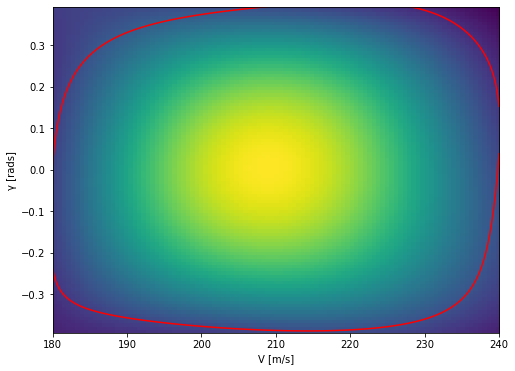

In [198]:
fig = plt.figure(figsize = (8, 6))
ax = plt.axes()

proj = output.reshape(N,N)
projim = ax.imshow(proj, extent=(Vmin,Vmax,ymin,ymax), aspect='auto')
# fig.colorbar(projim)

ax.contour(x.detach().numpy(), y.detach().numpy(), output, [0], colors=['red'])
ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]")

plt.savefig('../Figures/value_projection.png')
plt.show()